# Diffusion-deformation theories for hydrogels

Author: Jorge Urrea - 2024.01.17

## Introduction

We solve the transient nonlinear chemoelastic problem presented by Liu et al. (2016) using Fenics. This model describes the swelling kinetics of polymer gels. In this model both fields are fully coupled and it is assumed that the evolution is quasi-static, thus, the inertial effects are neglected. A staggered approach is adopted.

In [13]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# defining the top boundary of the plate
def top(x, on_boundary):
    return near(x[1], 1) and on_boundary
# defining the bottom boundary of the plate 
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
# defining the left boundary of the plate
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary
# defining the right boundary of the plate
def right(x, on_boundary):
    return near(x[0], 1) and on_boundary

In [15]:
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = -5.71 #-0.3124      # mu
    def value_shape(self):
        return (3,)

In [16]:
# Model parameters
# Elasticity parameters
# G0, χ = Constant(1.7e7), Constant(0.4)#Constant(0.2)
χ = Constant(0.2)
NΩ = Constant(1e-3)
Ω = Constant(1.7e-28)                          # the volume per solvent molecule
kBT = Constant(1.3806488e-23*298)              # T = 298 K
NkBT = Constant(1e25*1.3806488e-23*298)
D = Constant(0.2)#Constant(2e-4)#Constant(7.4e-11)                          # species diffusivity m^2 s^-1
mc = Constant(0.1)

In [17]:
# Kinematics
d = 2#u.geometric_dimension()
I = Identity(d)                         # Identity tensor

def F(u):
    return variable(I + grad(u)) 

# F = variable(I + grad(u))               # Deformation gradient
# C = F.T*F                             # Right Cauchy-Green tensor

# Left Cauchy-Green tensor
def B(u):
    return variable(F(u)*F(u).T)

# Invariants of deformation tensors
def Ic(u):
    return variable(tr(F(u).T*F(u)))
 
# Ic = tr(F(u).T*F(u))

def J(u):
    return variable(det(F(u)))

# J  = (det(F)) #1 + Ω*C

In [18]:
# Elasticity parameters
E, nu = 70e3, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
G0 = Constant(1e7)#Constant(40e3)#Constant(1e7/(1e25*1.3806488e-23*298))
print(E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model + chem potential)
def psi(u,µ): 
    return variable((G0/2)*(Ic(u) - 3 - 2*ln(J(u)))
                     + (kBT/Ω)*((J(u) - 0.999)*ln(1 - 0.999/J(u)) + χ*(1 - 0.999/J(u)))
                     - kBT*(µ/Ω)*(J(u) -1)) # <== This is working

40384.61538461538


In [19]:
# first Kirchooff stress - PK1 
def p_mu(u,µ):
    # return variable(-µ + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))
    return variable(-µ/(Ω) + 1/(Ω)*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2)))
# p_mu = -µ/Ω + kBT/Ω*(ln(1 - 0.999/J(u)) + 1/J(u) + χ/(J(u)**2))

def sigma(u,µ):
    return variable(p_mu(u,µ)*I + inv(J(u))*(G0)*(B(u) - I))
# sigma = p_mu*I + inv(J(u))*G0*(B(u) - I)

def PK1(u,µ):
    return variable(J(u)*sigma(u,µ)*inv(F(u).T))
# PK1 = J(u)*sigma(u,µ)*inv(F(u).T)

In [20]:
# Main solver function
def solver_slab(Nincr = 10, degree=1):

    N = 25
    mesh = UnitSquareMesh(N,N)

    # Form compiler options
    parameters["form_compiler"]["optimize"]     = True
    parameters["form_compiler"]["cpp_optimize"] = True

    ### Field variable function spaces
    element_u = VectorElement('CG', mesh.ufl_cell(), degree + 1)    # displacement finite element
    element_mu = FiniteElement('CG', mesh.ufl_cell(), degree)       # chemical potential finite element
    W = FunctionSpace(mesh, MixedElement([element_u, element_mu]))

    # zero displacement boundary conditions on the symmetric part of the plate
    u_bc_bottom = DirichletBC(W.sub(0).sub(1), Constant(0.0), bottom) 
    u_bc_right = DirichletBC(W.sub(0).sub(0), Constant(0.0), right)
    u_bc_left = DirichletBC(W.sub(0).sub(0), Constant(0.0), left)

    # chemical potential on the outer boundaries
    mu_bc_top = DirichletBC(W.sub(1), Constant(0.0), top)
    # mu_bc_left = DirichletBC(V.sub(1), Constant(µ_swell), left)
    mu_bc_right = DirichletBC(W.sub(1), Constant(0.0), right)

    # bcs = [u_bc_bottom, u_bc_right, mu_bc_top, mu_bc_left]
    # bcs = [u_bc_bottom, u_bc_left, mu_bc_top, mu_bc_right]
    bcs = [u_bc_bottom, u_bc_left, u_bc_right, mu_bc_top]

    # Trial and test functions
    dU = TrialFunction(W)
    (du, dµ) = split(dU)

    V_ = TestFunction(W)
    (v, q) = split(V_)

    U = Function(W)
    (u, µ) = split(U)

    Uold = Function(W)
    (uold, µold) = split(Uold)

    # Create intial conditions and interpolate
    u_init = InitialConditions()
    Uold.interpolate(u_init)

    dt = Constant(0.)

    # Total potential energy
    Psi_n = psi(u,µ)*dx# - inner(T, u)*ds
    Pi_mech = derivative(Psi_n, u, v) 

    Jac_mech = derivative(Pi_mech, u, du) + derivative(Pi_mech, µ, dµ)

    D = 0.2/NΩ # <= original value reported by Liu et al.
    # D = 0.15/NΩ
    # D = 2.2e-2 # concentration dependent
    def mr(u):
        return variable(J(u)*(D*(NΩ))*inv(B(u))) # <== This one applies neglecting diff dependency of cR

    # Mass balance
    Pi_chem = (
                (inner(J(u)*grad(u - uold),inv(F(u).T))*q)*dx 
                + dt*inner(mr(u)*grad(µ),grad(q))*dx)
               
    Pi = Pi_mech + Pi_chem 

    Jac_chem = derivative(Pi_chem, u, du) + derivative(Pi_chem, µ, dµ) 

    Jac = Jac_mech + Jac_chem
    
    t = np.linspace(0, 1, Nincr+1)
    Nx = 10
    x = np.linspace(0, 1.0, Nx)
    µ_res = np.zeros((Nx, Nincr+1))

    Jx_array = np.zeros((Nx, Nincr+1))
    sigma_y_array = np.zeros((Nx, Nincr+1))

    S = FunctionSpace(mesh, element_mu)

    for (i, dti) in enumerate(np.diff(t)):
        print("Increment " + str(i+1))
        dt.assign(dti)

        begin("2D FEM sol")
        solve(Pi == 0, U, bcs, J = Jac, solver_parameters={"newton_solver":
                                            {"convergence_criterion": "incremental","maximum_iterations": 200}})
            #     {"relative_tolerance": 1e-6, "linear_solver": "gmres", "convergence_criterion": "incremental", "relaxation_parameter": 0.9}})
        Uold.assign(U)
        # µ_res[:, i+1] = [U(xi, 0.5)[2] for xi in x]
        µ_res[:, i+1] = [U(0.5, xi)[2] for xi in x]

        (u, µ) = U.split()
        J_x = J(u)
        Jx_P1 = project(J_x, S)
        Jx_array[:, i+1] = [Jx_P1(0.5, xi) for xi in x] 
        # print(Jx_array)
        
        sigma_y = p_mu(u,µ)
        sigma_y_P1 = project(sigma_y, S)
        sigma_y_array[:, i+1] = [sigma_y_P1(0.5, xi) for xi in x]
        end()
    
    # Compute magnitude of displacement
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, S)
    return mesh, t, u_magnitude, µ, µ_res, Jx_array, sigma_y_array  

In [21]:
def solver_1D_ref_sol(Nincr = 10):

    # 1D NL PDE for lambda

    mesh_lambda = UnitIntervalMesh(200)

    element_lambda = FiniteElement('CG', mesh_lambda.ufl_cell(), 2)
    P = FunctionSpace(mesh_lambda, element_lambda)

    dlambda = TrialFunction(P)
    p = TestFunction(P)

    lamda = Function(P)
    lamda_old = Function(P)

    # Create initial condition
    lambda_init = Expression("1.0", degree=1)
    lamda_old.interpolate(lambda_init)
    lamda.assign(lamda_old)

    # BCs
    lambda_right = 1.498
    lambda_bc_left = DirichletBC(P, Constant(0.0), left)
    labmda_bc_right = DirichletBC(P, Constant(lambda_right), right)

    bc_lambda = labmda_bc_right

    dt = Constant(0.)

    def grad_lambda_X(lamda):
        return variable((1 + 1/(lamda**2))*grad(lamda)
                    + (1/NΩ)*(1/(lamda*(lamda - 0.99)) - 1/(lamda**2) - (2*χ)/(lamda**3))*grad(lamda))

    lambda_form = ((lamda - lamda_old)/dt*p #(1/NΩ)
                + dot((2.0e-4)*(1/lamda)*grad_lambda_X(lamda), grad(p)))*dx
                
    Jac_lambda = derivative(lambda_form, lamda, dlambda)

    t = np.linspace(0, 1, Nincr+1)
    # t = np.logspace(-2, 0, Nincr+1)
    Nx = 10
    x = np.linspace(0, 1.0, Nx)

    lambda_res = np.zeros((Nx, Nincr+1))

    for (i, dti) in enumerate(np.diff(t)):
        print("Increment " + str(i+1))
        dt.assign(dti)

        begin("Computing 1D lambda sol")
        solve(lambda_form == 0, lamda, bc_lambda, J=Jac_lambda)#, 
            # solver_parameters={'linear_solver': 'gmres',
            #                  'preconditioner': 'ilu'})
        lamda_old.assign(lamda)
        lambda_res[:, i+1] = [lamda(xi) for xi in x]
        end()

    return lambda_res

In [22]:
# Function to perform a mesh density convergence test

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

u_time = []
µ_time = []
µ_res_time = []
Jx_time = []
sigma_y_time = []

Nincr_array = [25, 50, 100, 200]
# Iterate over mesh sizes
for N in Nincr_array:
    print("Solving variational problem with " + str(N) + " time steps")
    mesh, t, u, µ, µ_res, Jx_array, sigma_y_array = solver_slab(N)

    u_time.append(u)
    µ_time.append(µ)
    µ_res_time.append(µ_res)
    Jx_time.append(Jx_array)
    sigma_y_time.append(sigma_y_array)

lambda_res = solver_1D_ref_sol(Nincr=100)

Solving variational problem with 25 time steps
Increment 1
2D FEM sol
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.452e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 2.101e+01 (tol = 1.000e-10) r (rel) = 3.256e+00 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 1.968e+01 (tol = 1.000e-10) r (rel) = 3.050e+00 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 4.754e+00 (tol = 1.000e-10) r (rel) = 7.368e-01 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 1.149e+00 (tol = 1.000e-10) r (rel) = 1.780e-01 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 1.727e-01 (tol = 1.000e-10) r (rel) = 2.676e-02 (tol = 1.000e-09)
    Newton iteration 6: r (abs) = 7.291e-03 (tol = 1.000e-10) r (rel) = 1.130e-03 (tol = 1.000e-09)
    Newton iteration 7: r (abs) = 2.464e-05 (tol = 1.000e-10) r (rel) = 3.819e-06 (tol = 1.000e-09)
    Newton iteration 8: r (abs) = 4.948e-10 (tol = 1.000e-10) r (rel) = 7.669e-11 (tol = 

In [23]:
# Computational obtained convergence order
print(Jx_time[3][0, -1])
print(Jx_time[2][0, -1])
print(Jx_time[1][0, -1])
print(Jx_time[0][0, -1])

conv_alpha = 1/np.log10(2)*np.log10( np.abs((Jx_time[1][0, -1] - Jx_time[2][0, -1])/(Jx_time[2][0, -1] - Jx_time[3][0, -1])))

print("Convergence computed for J at one point in the domain")
print(conv_alpha)

mesh = UnitSquareMesh(50,50)
element_mu = FiniteElement('CG', mesh.ufl_cell(), degree=1) 
S = FunctionSpace(mesh, element_mu)

u4 = project(u_time[3], S)
uh4 = u4(1,1)
print(uh4)

u2 = project(u_time[2], S)
uh2 = u2(1,1)
print(uh2)

u1 = project(u_time[1], S)
uh1 = u1(1,1)
print(uh1)

u0 = project(u_time[0], S)
uh0 = u0(1,1)
print(uh0)

conv_alpha_u = 1/np.log10(2)*np.log10( np.abs( (uh1 - uh2)/(uh2 - uh4)) )
print("Convergence computed for u at one point in the domain")
print(conv_alpha_u)

error_u4 = project(u_time[3] - u_time[2], S)**2*dx
E_u4 = sqrt(abs(assemble(error_u4)))
print(E_u4)

error_u2 = project(u_time[3] - u_time[1], S)**2*dx
E_u2 = sqrt(abs(assemble(error_u2)))
print(E_u2)

error_u = project(u_time[3] - u_time[0], S)**2*dx
E_u = sqrt(abs(assemble(error_u)))
print(E_u)

conv_alpha_error_u = 1/np.log10(2)*np.log10( np.abs( (E_u - E_u2)/(E_u2 - E_u4)) )
print("Convergence computed for u from L2 norm")
print(conv_alpha_error_u)

error_µ4 = project(µ_time[3] - µ_time[2], S)**2*dx
E_µ4 = sqrt(abs(assemble(error_µ4)))
print(E_µ4)

error_µ2 = project(µ_time[3] - µ_time[1], S)**2*dx
E_µ2 = sqrt(abs(assemble(error_µ2)))
print(E_µ2)

error_µ = project(µ_time[3] - µ_time[0], S)**2*dx
E_µ = sqrt(abs(assemble(error_µ)))
print(E_µ)

conv_alpha_error_µ = 1/np.log10(2)*np.log10( np.abs( (E_µ - E_µ2)/(E_µ2 - E_µ4)) )
print("Convergence computed for J from L2 norm")
print(conv_alpha_error_µ)

1.270810980712605
1.2698784938981442
1.268136105074862
1.2649296757374298
Convergence computed for J at one point in the domain
0.9019113742484657
0.33677258453241216
0.3360134297924872
0.3345904094454064
0.33195687881648
Convergence computed for u at one point in the domain
0.9064904024661247
0.0004966780948319947
0.0014267227154770936
0.0031447093683094275
Convergence computed for u from L2 norm
0.8853469891037004
0.0019332701525800113
0.005571257230565397
0.012353553674214509
Convergence computed for J from L2 norm
0.8986334251106356


/tmp/ipykernel_300/574322749.py:50: RuntimeWarning: divide by zero encountered in divide
  mu_x = 1.7e-28*1e7*(lambda_x - 1/lambda_x) + (1.3806488e-23*298)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))
/tmp/ipykernel_300/574322749.py:50: RuntimeWarning: invalid value encountered in log
  mu_x = 1.7e-28*1e7*(lambda_x - 1/lambda_x) + (1.3806488e-23*298)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))
/tmp/ipykernel_300/574322749.py:73: RuntimeWarning: divide by zero encountered in divide
  sigma_y = -mu_x/1.7e-28 + (1.3806488e-23*298/1.7e-28)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))
/tmp/ipykernel_300/574322749.py:73: RuntimeWarning: invalid value encountered in log
  sigma_y = -mu_x/1.7e-28 + (1.3806488e-23*298/1.7e-28)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))


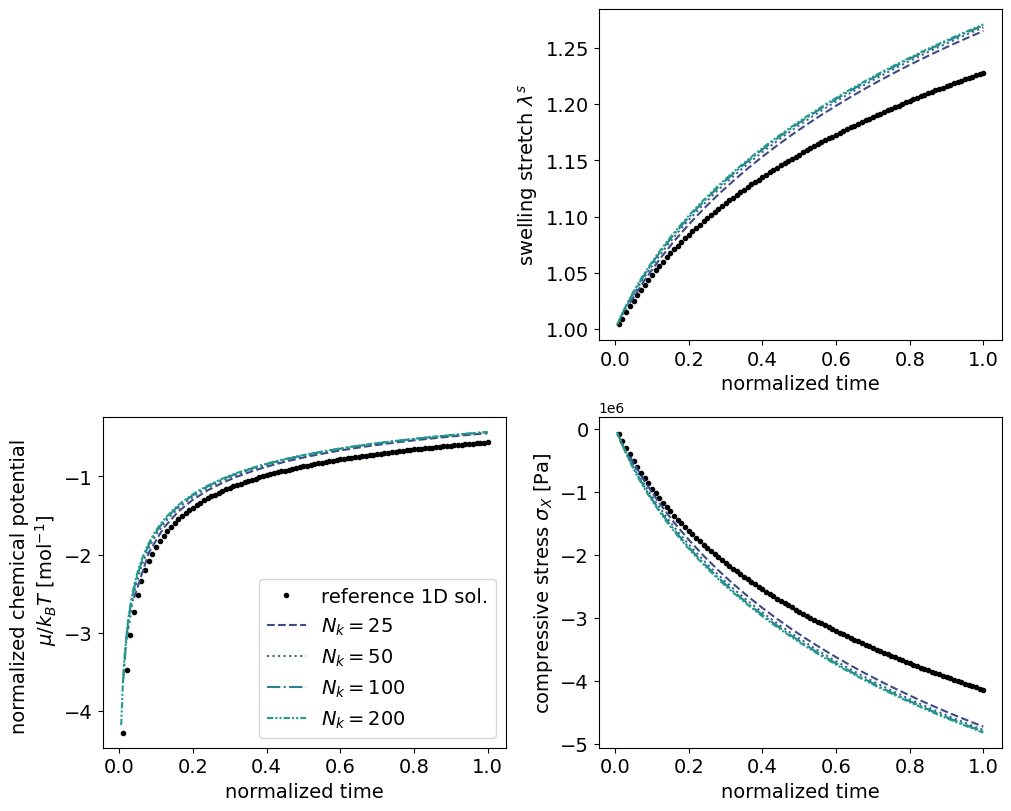

In [25]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from labellines import labelLine, labelLines

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,8))
axes = axes.flatten()

ax = axes[0]
ax.set_visible(False)

# create a list of linestyles
linestyles = ['--', ':', '-.', (0, (3, 1, 1, 1, 1, 1))]

# stretch
# fig, ax = plt.subplots()
ax = axes[1]

nValues = np.arange(0,10)
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.viridis

labels = []

Nincr = 100
t = np.linspace(0, 1, Nincr+1)
ax.plot(t[1:], lambda_res[0, 1:], 'k.')
labels.append("reference 1D sol.") 

time_steps = np.arange(0,len(Jx_time))
for m in time_steps:
    t = np.linspace(0, 1, Nincr_array[m]+1)
    ax.plot(t[1:], Jx_time[m][0, 1:], linestyle=linestyles[m], color=colormap(normalize(m+2)), label="$Nincr = {:.1f}$".format(Nincr_array[m]))
    labels.append("$N_{k} = $" + str(Nincr_array[m])) 

ax.set_xlabel("normalized time", fontsize=14)
ax.set_ylabel("swelling stretch $\lambda^s$", fontsize=14)
# ax.legend(labels, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# stress
# fig, ax = plt.subplots()
ax = axes[2]

lambda_x = lambda_res
mu_x = 1.7e-28*1e7*(lambda_x - 1/lambda_x) + (1.3806488e-23*298)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2))

Nincr = 100
t = np.linspace(0, 1, Nincr+1)
ax.plot(t[1:], mu_x[0, 1:]/(1.3806488e-23*298), 'k.')

time_steps = np.arange(0,len(Jx_time))
for m in time_steps:
    t = np.linspace(0, 1, Nincr_array[m]+1)
    ax.plot(t[1:], µ_res_time[m][0, 1:], linestyle=linestyles[m], color=colormap(normalize(m+2)), label="$Nincr = {:.1f}$".format(Nincr_array[m]))

ax.set_xlabel("normalized time", fontsize=14)
ax.set_ylabel("normalized chemical potential \n $\mu/k_B T$ [mol$^{-1}$]", fontsize=14)
ax.legend(labels, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# stresses
# fig, ax = plt.subplots()
ax = axes[3]

sigma_y = -mu_x/1.7e-28 + (1.3806488e-23*298/1.7e-28)*(np.log(1 - 1/lambda_x) + 1/lambda_x + 0.2/(lambda_x**2)) 

Nincr = 100
t = np.linspace(0, 1, Nincr+1)
ax.plot(t[1:], sigma_y[0, 1:], 'k.')

time_steps = np.arange(0,len(Jx_time))
for m in time_steps:
    t = np.linspace(0, 1, Nincr_array[m]+1)
    ax.plot(t[1:], (1.3806488e-23*298)*sigma_y_time[m][0, 1:], linestyle=linestyles[m], color=colormap(normalize(m+2)), label="$Nincr = {:.1f}$".format(Nincr_array[m]))

ax.set_xlabel("normalized time", fontsize=14)
ax.set_ylabel("compressive stress $\sigma_X$ [Pa]", fontsize=14) 
# ax.legend(labels, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# plt.savefig('results/Liu/Fig_refsol_2DFEM_equal_D_time_converg.pdf')
# plt.savefig('results/Liu/Fig_refsol_2DFEM_time_converg.pdf')
